# Fake News Classifier 
Created by Jamil Abbas   
Last Updated: 2021-02-09 

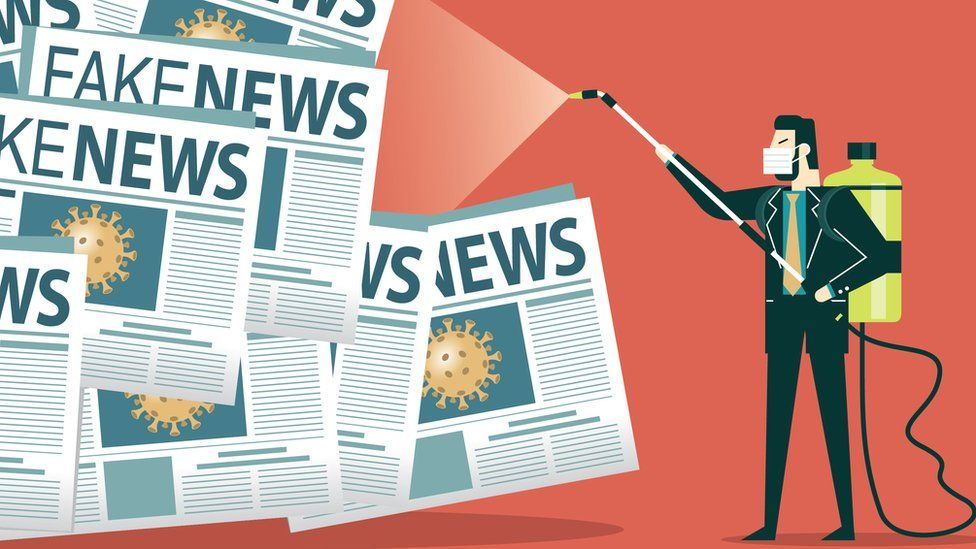$^3$  
  
Fake news is defined as false news stories, often of a sensational nature, created with the intent of generating revenue or to promote/degrade a politician, public figure, company etc.$^1$ 
It seems foolish that these outlandish fabrications are to be taken seriously, but we have already seen the large scale danger that fake news possesses. Considering the widespread topics that the masses depend on the news for (politics, business, finance, world events and so on), it's safe to say that the news plays a crucial role and is relied upon in multiple aspects of our day to day lives and hence it's dangers cannot be underestimated. 
The biggest example is that democracy is dependent on accurate news being delivered to the people so that they are well informed when it comes time to make a decision for who to vote for. In addition, the more fake news being published hurts the real news as now it poses as a competitor and reduces it's impact by undermining the public's trust in serious media coverage. Throughout the 2016 presidential election, there was more engagement and activity regarding fake news articals/posts on Facebook than news published from major media outlets.$^4$   

The next step is to suppress fake news and ensure that only correct information is articulated to the general public. Social media is one of the largest mediums for fake news due to the nonexistent barriers to publication and large targeted audiences that are able to be communicated to around the world. 
Only recently have we seen social media platforms (Facebook, Twitter, Instagram) begin to implement algorithms that detect and label fake news as misinformation, and this is due to the fact that social media platforms operate on vague boundaries between the types of content they censor as it interferes with the right to freedom of speech.
There exists a plethora of similarities between misinformation and extreme opinions, but given that we have seen large scale misinformation with malicious intent being communicated through social media platforms, these platforms are beginning to crack down and regulate the news that is being published.  

In order for fake news to be regulated there needs to be a method of fact checking and classifying what news is accurate and what news is inaccurate. The aim of this model is to illustrate a method of classifying news articles as 'real' or 'fake' so that the dangers of misinformation can be avoided. 
The model utilizes a TF-IDF vectorizer to transform a set of fake and real news data$^2$ into a measure that can be modeled through a logistic regression. 

In [1]:
####################
# REQUIRED MODULES #
####################
import string
import nltk

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline

## Importing the Data 

In [2]:
#import the data, add labels for analysis (0 for real news, 1 for fake news)
fake_news = pd.read_csv('Fake.csv')
fake_news['label'] = 1
fake_news.head(3)

In [3]:
real_news = pd.read_csv('True.csv')
real_news['label'] = 0
real_news.head(3)

In [4]:
#Concatenate both dataframes into one and clean the dataset (lowercase, remove puntuation, remove stopwords)
news = pd.concat([real_news, fake_news])
#Drop 'title' and 'date' features as this won't be required for training the models
news.drop(['date'], axis = 1, inplace = True)

news.shape
news.info() #Check for null values 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   label    44898 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


From the output above it is apparent that there isn't any null values in the dataset, but after close examination there appears to be a number of data points that contain a single space in the 'text' feature. Even though the title provides important data, and later on we will be merging the title and text features into a single feature and apply the TF-IDF vectorizer to all of them, we remove these data points with only a title. 

In [5]:
#Check data for any entires with no data in 'text' and remove these data points 
news[news.text == '']
news.drop(news[news.text == ''].index.tolist(), inplace=True)
news.shape

(44898, 4)

In [6]:
#Check for duplicates in the data (by 'text') and drop them from the main dataframe
news.drop('label', axis=1)[news.duplicated(keep=False)]
news.drop(news[news.duplicated()].index.tolist(), inplace=True)
news.shape

(44473, 4)

In [7]:
#Shuffle the data to help prevent any bias from occuring during analysis
news = shuffle(news)
news = news.reset_index(drop=True)
news.head(3)

## Explore/visualize the data 

### Number of Articles per Subject

subject
Government News     1564
Middle-east          778
News                9002
US_News              783
left-news           4438
politics            6703
politicsNews       11216
worldnews           9989
Name: text, dtype: int64


<function matplotlib.pyplot.show(*args, **kw)>

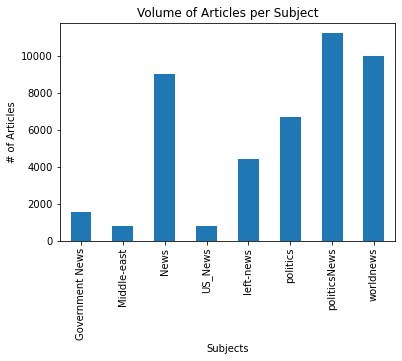

In [8]:
print(news.groupby(['subject'])['text'].count())
news.groupby(['subject'])['text'].count().plot(kind='bar')
plt.title('Volume of Articles per Subject')
plt.xlabel('Subjects')
plt.ylabel('# of Articles')
plt.show

### Number of Real/Fake News Articles

label
0    21205
1    23268
Name: text, dtype: int64


([0, 1], <a list of 2 Text major ticklabel objects>)

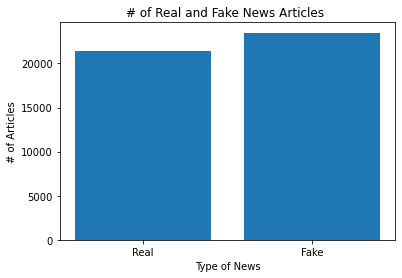

In [9]:
print(news.groupby(['label'])['text'].count())
x1 = ['Real', 'Fake']
y1 = [21417, 23481]
plt.bar(x1,y1)
plt.title('# of Real and Fake News Articles ')
plt.xlabel('Type of News')
plt.ylabel('# of Articles')
plt.show
plt.xticks(rotation = 0)

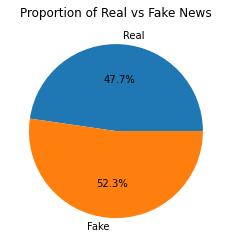

In [10]:
labels = 'Real' , 'Fake'
fig1, ax1 = plt.subplots()
ax1.pie(y1, labels=labels, autopct='%1.1f%%')
plt.title('Proportion of Real vs Fake News')
plt.show()

## Clean/Prepare the Data

In [11]:
#First combine 'title' and 'text' into a single feature: 'text' and delete 'title' and 'subject'
news['text'] = news['title'] + ' ' + news['text']
del news['title']
del news['subject']
news.head(3)

,text,label
0,"Bernie Gives Us Hope, Promises To Protect Min...",1
1,"McDonald's deletes Trump tweet, says Twitter a...",0
2,CLASSLESS KENNEDY FAMILY With History Of Phila...,1


In [12]:
#Clean the 'text' feature (remove puncuation, stopwords, lowercase)

#Set 'text' to lowercase
news['text'] = news.text.str.lower()

#Remove any punctuation from 'text'
news['text'] = news['text'].str.translate(str.maketrans('', '', string.punctuation))

#Remove any stopwords from 'text'
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords = stopwords.words('english')
news['text'] = news['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Highest Word Frequency in Real and Fake News 

said          97801
trump         46273
us            44352
would         31278
reuters       28060
president     25398
state         18961
government    17979
house         17578
new           17405
states        16011
republican    15807
also          15741
united        15395
people        14499
told          14106
could         13701
last          12506
one           12263
washington    12114
dtype: int64


<function matplotlib.pyplot.show(*args, **kw)>

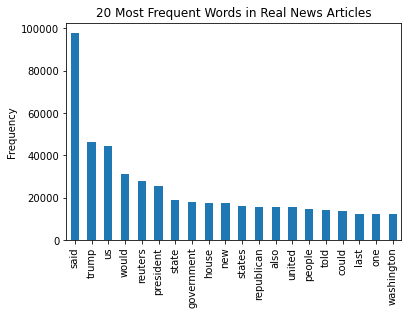

In [13]:
# Top 20 most frequently used words in real news articles
realn = news[news['label'] == 0]
print(realn.text.str.split(expand=True).stack().value_counts().nlargest(20))
realn.text.str.split(expand=True).stack().value_counts().nlargest(20).plot(kind='bar')
plt.title('20 Most Frequent Words in Real News Articles')
plt.ylabel('Frequency')
plt.show

trump        79778
said         30984
president    26231
people       26194
would        23503
one          23277
us           22815
obama        19379
clinton      18823
like         17862
donald       17773
video        15951
hillary      15147
also         15136
new          14895
news         14739
even         13760
white        13431
time         12852
state        12825
dtype: int64


<function matplotlib.pyplot.show(*args, **kw)>

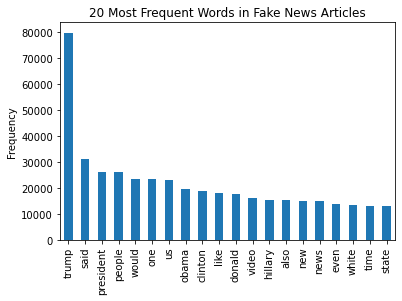

In [14]:
# Top 20 most frequently used words in fake news articles
faken = news[news['label'] == 1]
print(faken.text.str.split(expand=True).stack().value_counts().nlargest(20))
faken.text.str.split(expand=True).stack().value_counts().nlargest(20).plot(kind='bar')
plt.title('20 Most Frequent Words in Fake News Articles')
plt.ylabel('Frequency')
plt.show

## Split the Data into train and test sets

In [ ]:
#Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(news.drop('label', axis=1), news.label, test_size = 0.2, random_state=40)
print('Train test data size: ', X_train.shape, y_train.shape)
print('Test test data size: ', X_test.shape, y_test.shape)

## Apply TF-IDF vectorizer 

In [18]:
vectorizer = TfidfVectorizer(min_df=0.01, ngram_range=(1,3))
vectorizer.fit(X_train.text)

#Fit the training and test data
X_train_v = vectorizer.transform(X_train.text)
X_test_v = vectorizer.transform(X_test.text)

print(X_train_v.shape, X_test_v.shape)

(35578, 3510) (8895, 3510)


## Fit the Logistic Regression Model

In [32]:
model = LogisticRegression(C=2.5)
model.fit(X_train_v, y_train)

#Check accuracy of the model
predicted_value = model.predict(X_test_v)
accuracy_val = roc_auc_score(y_test, predicted_value)
print('Accuracy: ' , 100*accuracy_val , '%')
print(classification_report(y_train.values, model.predict(X_train_v)))

Accuracy:  99.43979261237304 %
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16959
           1       1.00      1.00      1.00     18619

    accuracy                           1.00     35578
   macro avg       1.00      1.00      1.00     35578
weighted avg       1.00      1.00      1.00     35578



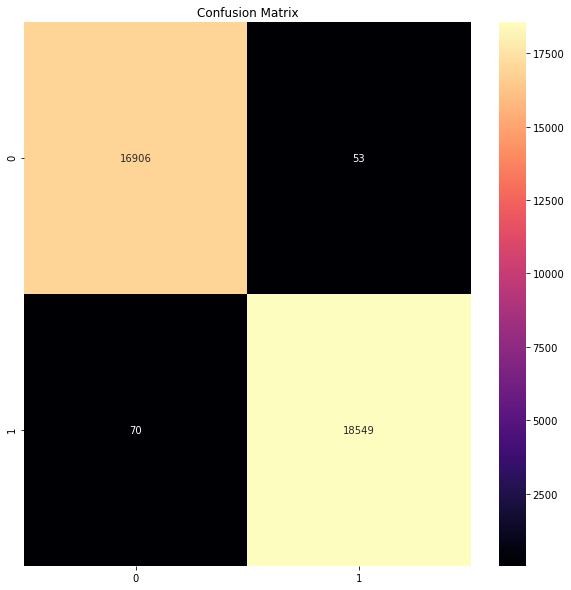

In [41]:
#Plot the confusion matrix
cm = confusion_matrix(y_train, model.predict(X_train_v))
plt.figure(figsize=(10,10))
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True, fmt='g', cmap='magma')

## Observations

 - Initally it was intended that we apply a deep learning machine learning algorithm to classify real and fake news, but given the fact that good results were obtained from a simple and easy to interpret model deep learning was not applied.   
 - Other classifiers were tried (SGD with log loss and SVM) but these did not show any significant improvement compared to the logistic regression model. 

## References
$1$: Dictionary.com, "Fake News", Accessed 2021-01-31, Online: https://www.dictionary.com/browse/fake-news      
$2$: Kaggle, Clément Bisaillon, "Fake and real news dataset", Accessed 2021-01-17, Online: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset    
$3$: BBC, "Tech Tent: Social media fights a fresh flood of fake news", Accessed 2021-02-07, Online: https://www.bbc.com/news/technology-52245992  
$4$: Buzzfeed, Craig Silverman, "This Analysis Shows How Viral Fake Election News Stories Outperformed Real News On Facebook", Accessed 2021-02-07, Online: https://www.buzzfeednews.com/article/craigsilverman/viral-fake-election-news-outperformed-real-news-on-facebook    